![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Exercise 7 - Transformer </center>
### <center> Music Classification - Solution </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/Exercises/Ex7/Exercise07_Transformer.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchinfo
import torchaudio

import IPython.display as ipd

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/Exercises/Ex7/DeepLearningFramework ./DeepLearningFramework

### Exercise:
Get above 50% accuracy on the GTZAN dataset.

#### Load the data:

In [5]:
from torchaudio.datasets import GTZAN

oTrainSet = GTZAN(root='../../../data', subset='training',   download=True)
oTestSet  = GTZAN(root='../../../data', subset='validation', download=True)

nTrain    = len(oTrainSet)
nTest     = len(oTestSet)
nTrain, nTest

(443, 197)

#### Display a single example:

In [6]:
idx       = np.random.randint(nTrain)
vX, Fs, y = oTrainSet[idx]

display(ipd.Audio(vX, rate=Fs))
vX.shape, Fs, y

(torch.Size([1, 661794]), 22050, 'blues')

#### waveform:

In [7]:
L  = vX.shape[1]
T  = L / Fs
tt = np.linspace(0, T, L, endpoint=False)
T

30.013333333333332

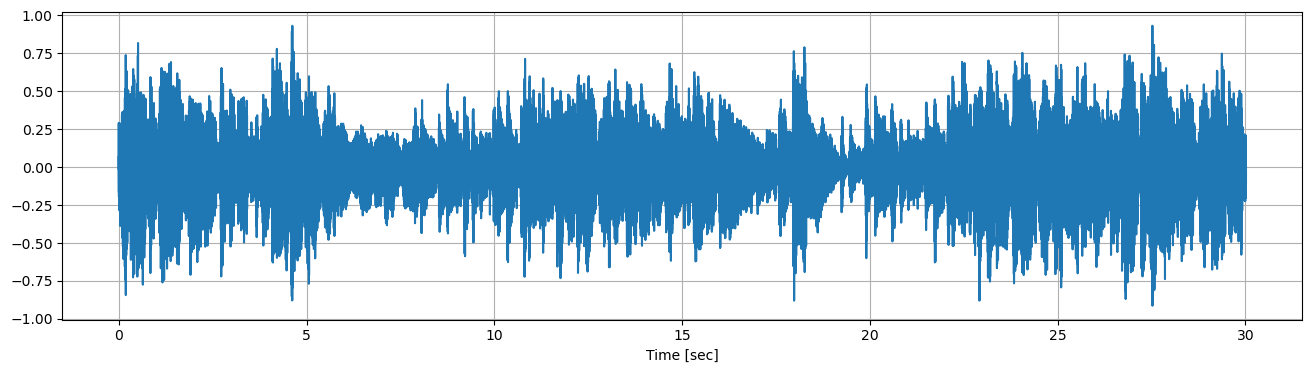

In [8]:
plt.figure(figsize=(16, 4))
plt.plot  (tt, vX[0])
plt.xlabel('Time [sec]')
plt.grid  ()
plt.show  ()

#### (log) Spectrogram:

In [9]:
import torchaudio.transforms as transforms

def Spectrogram(vX):
    mS = transforms.Spectrogram(n_fft=512)(vX)[:-1,:]
    mS = torch.log10(mS + .1)
    
    return mS

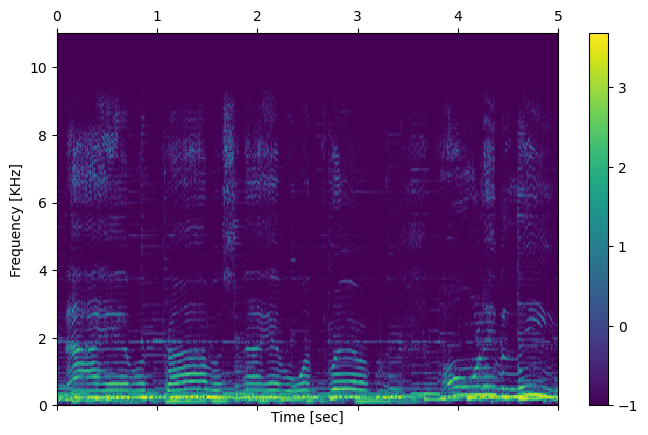

In [10]:
Ti = 5
mS = Spectrogram(vX[0,:Ti*Fs])

plt.matshow (mS, origin='lower', extent=[0, Ti, 0, Fs//2000], aspect='auto')
plt.xlabel  ('Time [sec]')
plt.ylabel  ('Frequency [KHz]')
plt.colorbar()
plt.show    ()

#### Label encoder:

In [11]:
lLabels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [12]:
from sklearn.preprocessing import LabelEncoder

oLabelEncoder = LabelEncoder().fit(lLabels)
nLabels       = len(oLabelEncoder.classes_)

print(f'Number of labels: {nLabels}'               )
print(f'Labels:         \n{oLabelEncoder.classes_}')

Number of labels: 10
Labels:         
['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


#### Dataset:
* The duration of each original sample is 30 seconds.  
* The following dataset returns a `T=3` seconds window from each sample.

In [13]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, oDataset, Fs, T, bTrain=False):
        self.oDataset = oDataset
        self.L        = int(T * Fs)
        self.bTrain   = bTrain
        self.nSplits  = 9 #-- Some signals are less than 30s so we split to 9 and not 10.
        
    def __len__(self):
        return self.nSplits * len(self.oDataset)
    
    def __getitem__(self, idx):
        nSplits = self.nSplits
        subIdx  = idx %  nSplits
        idx     = idx // nSplits
        L       = self.L
        start   = subIdx * L
        end     = start  + L
        
        #-- A random shift
        if self.bTrain == True and subIdx != (nSplits - 1):
            shift  = np.random.randint(L)
            start += shift
            end   += shift
        
        vX, _, label = self.oDataset[idx]
        vX           = vX[0,start:end]
        
        #-- Spectrogram:
        mS = Spectrogram(vX).T
        y  = oLabelEncoder.transform([label])[0]
        y  = torch.tensor(y, dtype=torch.long)
        
        return mS, y
    
#-----------------------------------------------------#
#-----------------------------------------------------#
Ti           = 3
oTrainSetAux = AudioDataset(oTrainSet, Fs, T=Ti, bTrain=True)
oTestSetAux  = AudioDataset(oTestSet,  Fs, T=Ti)

len(oTrainSetAux), len(oTestSetAux)

(3987, 1773)

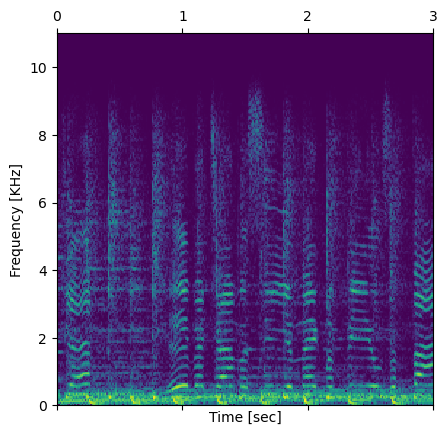

(torch.Size([259, 256]), tensor(0))

In [14]:
mX, y = oTrainSetAux[100]

plt.matshow(mX.T, origin='lower', extent=[0, Ti, 0, Fs//2000], aspect='auto')
plt.xlabel ('Time [sec]')
plt.ylabel ('Frequency [KHz]')
plt.show   ()

mX.shape, y

#### Data-loader:

In [15]:
from torch.utils.data import DataLoader

batchSize = 128
oTrainDL  = DataLoader(oTrainSetAux, shuffle=True,  batch_size=batchSize)
oTestDL   = DataLoader(oTestSetAux,  shuffle=True,  batch_size=2*batchSize)

mX,       vY = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([128, 259, 256]), torch.Size([128]))

#### Model #1 - CNN
Write a CNN based model that outputs `512` features.

In [16]:
class ConvBlock(nn.Module):
    def __init__(self, cIn, cOut, kernelSize, stride=1, bActivation=True):
        super(ConvBlock, self).__init__()

        padding = kernelSize // 2
        oConv   = nn.Conv2d(cIn, cOut, kernel_size=kernelSize, padding=padding, stride=stride, bias=not bActivation)
        if bActivation == True:
            self.oBlock = nn.Sequential(oConv, nn.BatchNorm2d(cOut), nn.LeakyReLU(0.1))
        else:
            self.oBlock = nn.Sequential(oConv)

    def forward(self, mX):
        return self.oBlock(mX)
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#
class ResBlock(nn.Module):
    def __init__(self, cIn):
        super(ResBlock, self).__init__()
        
        self.oBlock = nn.Sequential(
            ConvBlock(cIn,    cIn//2, kernelSize=1),
            ConvBlock(cIn//2, cIn,    kernelSize=3)
        )

    def forward(self, mX):
        return mX + self.oBlock(mX)
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.oNN = nn.Sequential(
            ???
            
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )                  

    def forward(self, mX):
        return self.oNN(mX[:,None,:,:])
            
torchinfo.summary(CNN(), mX.shape)

Layer (type:depth-idx)                             Output Shape              Param #
CNN                                                --                        --
├─Sequential: 1-1                                  [128, 512]                --
│    └─ConvBlock: 2-1                              [128, 16, 130, 128]       --
│    │    └─Sequential: 3-1                        [128, 16, 130, 128]       176
│    └─Dropout2d: 2-2                              [128, 16, 130, 128]       --
│    └─ConvBlock: 2-3                              [128, 32, 65, 64]         --
│    │    └─Sequential: 3-2                        [128, 32, 65, 64]         4,672
│    └─Dropout2d: 2-4                              [128, 32, 65, 64]         --
│    └─ResBlock: 2-5                               [128, 32, 65, 64]         --
│    │    └─Sequential: 3-3                        [128, 32, 65, 64]         5,216
│    └─Dropout2d: 2-6                              [128, 32, 65, 64]         --
│    └─ConvBlock: 2-7       

#### Model #2 - Transformer
Write a Transformer based model that outputs `512` features.  
(You can consider only the last column of the transformer output just to shrink the model size.)

In [17]:
D = 256
L = 259
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        
        self.oEmbeedingPos = nn.Embedding              (L, D)
        oEncoderLayer      = nn.TransformerEncoderLayer(d_model=D, nhead=4, dropout=0.1)
        self.oTransformer  = nn.TransformerEncoder     (oEncoderLayer, 2)
        self.oLinear       = nn.Linear                 (D, 512)
    
    def forward(self, mX):
        mH = self.oTransformer(mX)
        mZ = self.oLinear     (mH[:,-1])
        
        return mZ
    
torchinfo.summary(Transformer(), mX.shape)

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   --                        --
├─TransformerEncoder: 1                       --                        --
│    └─ModuleList: 2-1                        --                        --
├─TransformerEncoder: 1-1                     [128, 259, 256]           --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [128, 259, 256]           1,315,072
│    │    └─TransformerEncoderLayer: 3-2      [128, 259, 256]           1,315,072
├─Linear: 1-2                                 [128, 512]                131,584
Total params: 2,235,392
Trainable params: 2,235,392
Non-trainable params: 0
Total mult-adds (M): 286.13
Input size (MB): 33.95
Forward/backward pass size (MB): 1494.22
Params size (MB): 8.94
Estimated Total Size (MB): 1537.11

### Joint Model
CNN + Transformer + Linear

In [32]:
class JointModel(nn.Module):
    def __init__(self):
        super(JointModel, self).__init__()
        
        self.oCNN         = CNN        ()
        self.oTransformer = Transformer()
        self.oFC          = nn.Sequential(
                                nn.Linear(1024, 256), nn.ReLU(),
                                nn.Linear(256, 10)
                            )
     
    def forward(self, mX):
        mCNN         = self.oCNN        (???)
        mTransformer = self.oTransformer(???)
        mZ           = torch.cat        (???)
        mZ           = self.oFC         (???)
        
        return mZ
        
torchinfo.summary(JointModel(), mX.shape)

Layer (type:depth-idx)                                  Output Shape              Param #
JointModel                                              --                        --
├─Transformer: 1                                        --                        --
│    └─TransformerEncoder: 2                            --                        --
│    │    └─ModuleList: 3-1                             --                        2,630,144
├─CNN: 1-1                                              [128, 512]                --
│    └─Sequential: 2-1                                  [128, 512]                --
│    │    └─ConvBlock: 3-2                              [128, 16, 130, 128]       176
│    │    └─Dropout2d: 3-3                              [128, 16, 130, 128]       --
│    │    └─ConvBlock: 3-4                              [128, 32, 65, 64]         4,672
│    │    └─Dropout2d: 3-5                              [128, 32, 65, 64]         --
│    │    └─ResBlock: 3-6                        

In [33]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy
from DeepLearningFramework.Losses   import LabelSmoothingLoss

DEVICE = torch.device      ("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = LabelSmoothingLoss(len(oLabelEncoder.classes_))
Metric = Accuracy          ()

In [34]:
nEpochs    = 100
nIter      = nEpochs * len(oTrainDL)

oModel     = JointModel ().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=1)
oScheduler = OneCycleLR (oOptim, max_lr=5e-4, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, sModelName='GTZANJointModel')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  2.228 | Val loss:  2.272 | Train Metric:  0.206 | Val Metric:  0.102 | epoch time: 17.509 | <-- Checkpoint!
Epoch 001: | Train loss:  2.094 | Val loss:  2.230 | Train Metric:  0.273 | Val Metric:  0.127 | epoch time: 17.215 | <-- Checkpoint!
Epoch 002: | Train loss:  1.965 | Val loss:  2.218 | Train Metric:  0.329 | Val Metric:  0.164 | epoch time: 17.041 | <-- Checkpoint!
Epoch 003: | Train loss:  1.836 | Val loss:  2.200 | Train Metric:  0.377 | Val Metric:  0.215 | epoch time: 17.246 | <-- Checkpoint!
Epoch 004: | Train loss:  1.739 | Val loss:  2.059 | Train Metric:  0.394 | Val Metric:  0.255 | epoch time: 16.975 | <-- Checkpoint!
Epoch 005: | Train loss:  1.654 | Val loss:  2.084 | Train Metric:  0.426 | Val Metric:  0.260 | epoch time: 17.271 | <-- Checkpoint!
Epoch 006: | Train loss:  1.602 | Val loss:  1.949 | Train Metric:  0.445 |

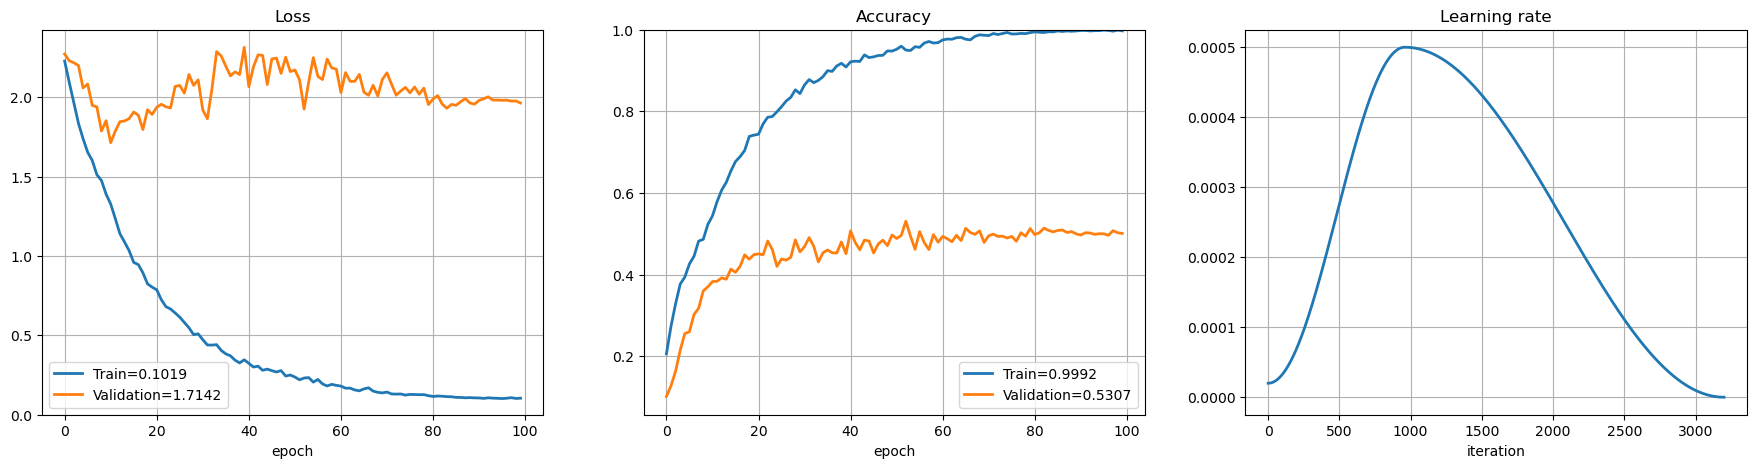

In [35]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

### Predict
* The model input is a 3 second long signal.
* Given a full signal (~30 seconds) we split it into windows of 3 seconds.
* We predict each window and take the average.

In [36]:
def Predict(oModel, vX):
    mS = Spectrogram(vX).T
    mX  = torch.stack(torch.split(mS, L, dim=0)[:-1])
        
    with torch.no_grad():
        
        mZ   = oModel(mX[:,:,:].to(DEVICE))
        yHat = mZ.softmax(1).mean(0).argmax()
        
    return yHat

#### Confusion matrix:

In [37]:
nTest = len(oTestSet)
vY    = torch.empty(nTest)
vHatY = torch.empty(nTest)

for ii, (vX, Fs, label) in enumerate(oTestSet):
    vY   [ii] = oLabelEncoder.transform([label])[0]
    vHatY[ii] = Predict(oModel, vX[0])

(vHatY == vY).float().mean()

tensor(0.5685)

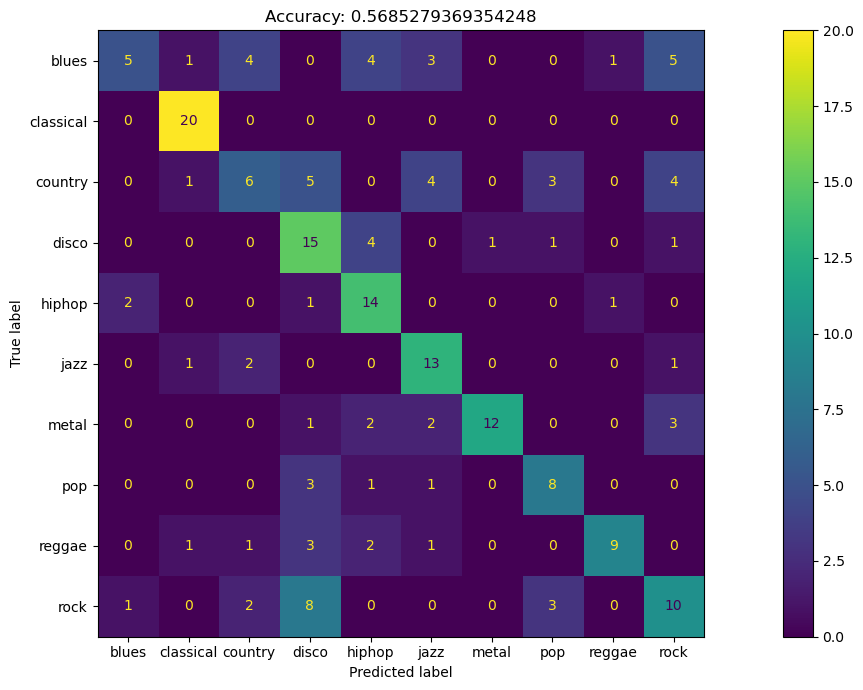

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#-- Compute confusion matrices:
mConfusion = confusion_matrix(vY.cpu(), vHatY.cpu())

_, ax = plt.subplots(1, 1, figsize=(16,7))
ConfusionMatrixDisplay(mConfusion, display_labels=oLabelEncoder.classes_).plot(values_format='g', ax=ax)

mean = (vY.cpu() == vHatY.cpu()).float().mean().item()
ax.set_title    (f'Accuracy: {mean}')
plt.tight_layout()
plt.show        ()